In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from baynes.model_utils import inits_from_priors
from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
import pandas as pd
#plt.style.use('ggplot')
import numbers

In [4]:
def lorentzian(E, E0, gamma):
    gamma_2 = gamma / 2
    return 1/np.pi * gamma_2 / ((E - E0) ** 2+gamma_2 ** 2)


def HoSpectrum(E,  m_nu,
                         Q_H=2838,
                         E_H=[2047, 1842, 414.2, 333.5, 49.9, 26.3],
                         gamma_H=[13.2, 6.0, 5.4, 5.3, 3.0, 3.0],
                         i_H=[1, 0.0526, 0.2329, 0.0119, 0.0345, 0.0015]):
    if isinstance(E, numbers.Number):
        spectrum =  np.array([0.])
    else:
        spectrum = np.zeros(len(E))
    for i in range(len(E_H)):
        spectrum += i_H[i]*lorentzian(E, E_H[i], gamma_H[i])
    return np.clip((Q_H - E), 0, None)*np.sqrt(np.clip((Q_H - E)**2 - m_nu**2, 0, None)) * spectrum


def hdi(samples, prob=0.95):
    n = len(samples)
    sorted_samples = np.sort(samples)
    interval_len = int(np.floor(prob * n))
    n_intervals = n - interval_len
    interval_widths = np.subtract(sorted_samples[interval_len:], sorted_samples[:n_intervals])

    min_idx = np.argmin(interval_widths)
    hdi_interval = sorted_samples[[min_idx, min_idx + interval_len]]

    return hdi_interval

In [4]:
stan_file= "Ho_spectrum.stan"
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":4})

11:28:44 - cmdstanpy - INFO - compiling stan file /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.stan to exe file /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst
11:29:28 - cmdstanpy - INFO - compiled model executable: /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst
11:29:28 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
11:29:28 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum --o=/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.hpp /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.stan
Warning in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.stan', line 48, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warn

Number of events in ROI:  3231820


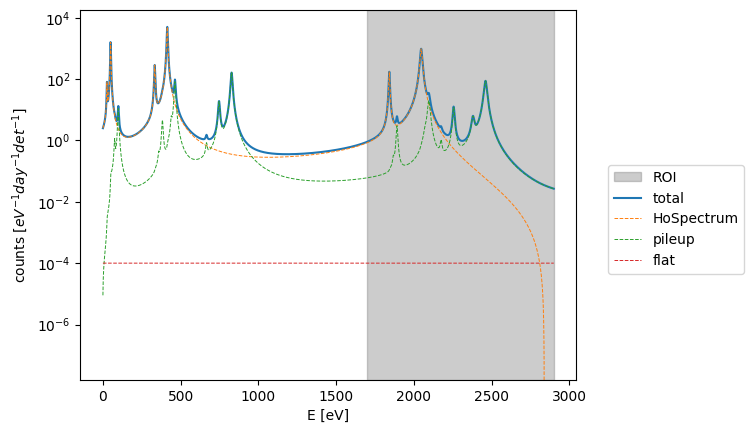

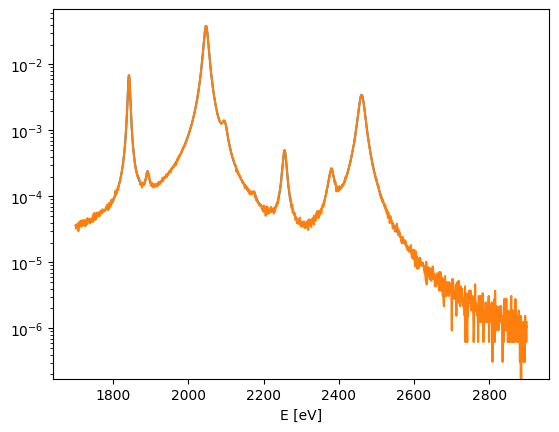

In [5]:
FWHM=0
m = 0
bkg = 1e-4
n_days = 2
A_Ho = 1

s = SpectraSampler([(HoSpectrum, [m], A_Ho)], flat_bkg=bkg, f_pileup=0.1, FWHM=FWHM,  n_spectra=1, dE=1, integrate=False, ROI=[1700, 2900])
s.plot_spectrum()
s.set_measure_time(n_days, n_det=64)
true_weights = s.weights_in_ROI

x = s.bin_edges[s.ROI_idx[0]:s.ROI_idx[1]+1]
events = s.sample()[0]
ax = s.plot_pdf()
ax.plot(s.ROI_bin_centers, events/np.sum(events))

n_window = 181

data={'N_bins': len(x)-1, 
      'N_window': n_window,
      'N_peaks': 2,
      'x': x, 
      'counts': events,
      'p_Q': 2838,
      'p_m': 40,
      'p_FWHM': FWHM,
      'p_N': s.n_events,
      'prior': 0,
      'p_x0': [1850, 2050],
      'p_h': [0.1,1],
      'bkg': true_weights[1]
      #'p_g': [8,8]
}

In [20]:
def simple_analysis(model, data, plot, sampler_kwargs, fit_title='fit', rep_key='counts_rep', data_key='counts', true_params=None):
    data['prior']=1
    fit_prior = model_sigma.sample(data, **sampler_kwargs)
    plot.add_fit(fit_prior, fit_title=fit_title+'_prior')
    plot.predictive_check(rep_key, data=data, data_key=data_key)
    plot.kde_plot(hue='variable')

    sampler_kwargs['inits'] = inits_from_priors(model_sigma, fit_prior, sampler_kwargs['chains'])
    data['prior']=0
    fit = model_sigma.sample(data, **sampler_kwargs)
    
    print(fit.diagnose())

    plot.add_fit(fit, fit_title='sigma')
    plot.convergence_plot(initial_steps=100)
    plot.predictive_check(rep_key, data=data, data_key=data_key)
    plot.kde_plot(hue='variable')
    if true_params is not None:
        plt.close()
        plot.add_lines(true_params)
        plot.get_current_figure()
    return fit_prior, fit

sampler_kwargs={
    'chains': 4,
    'iter_warmup': 600,
    'iter_sampling': 600,
    'save_warmup': True, 
    'adapt_delta': 0.9
}

p = FitPlotter(col_wrap=4)
simple_analysis(model_sigma, data, p, sampler_kwargs, fit_title='sigma')

11:28:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:10:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:10:11 - cmdstanpy - INFO - CmdStan done processing.


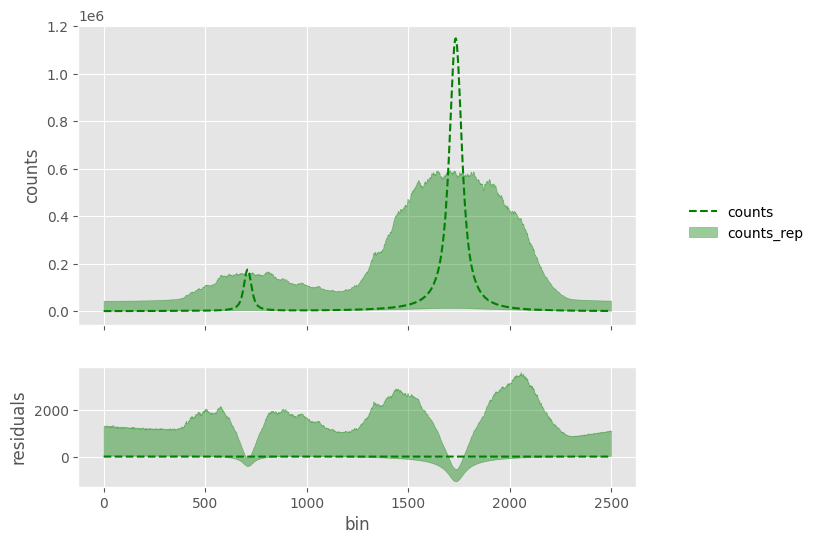

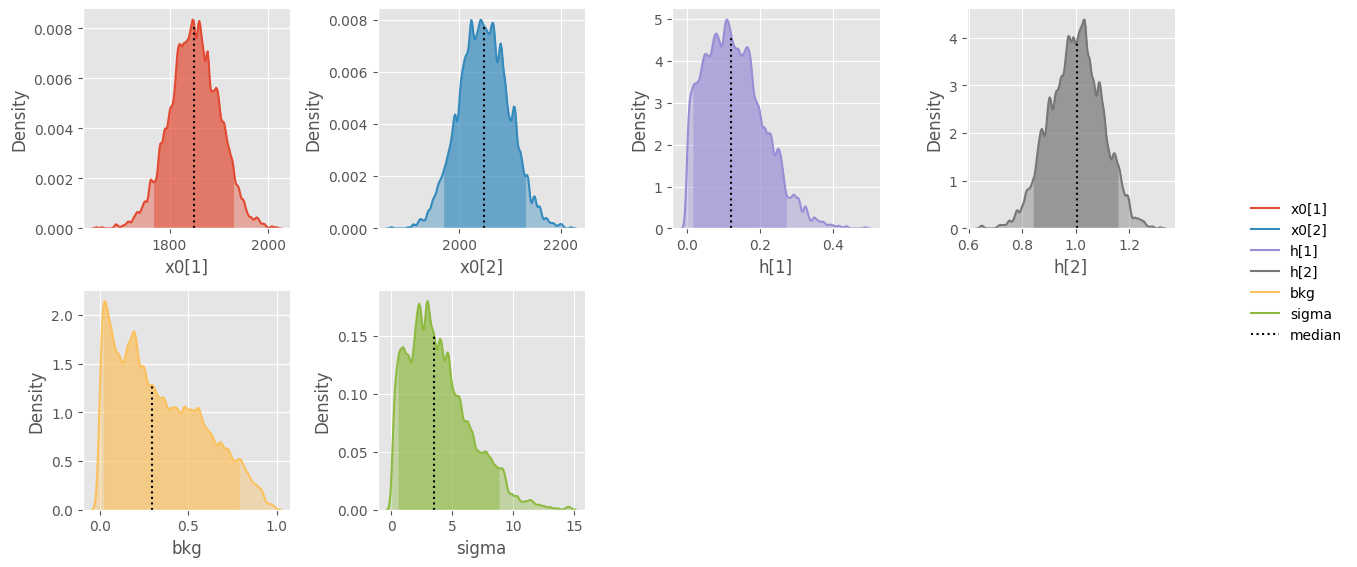

In [29]:
data['prior']=1
fit_prior = model_sigma.sample(data,
                   chains=4,
                   iter_warmup=200,
                   iter_sampling=800,
                   save_warmup=True,
                   inits = {'sigma': 3},
                   show_progress=True)

plotter = FitPlotter(fit_prior, fit_title='prior_m=0', col_wrap=4)
plotter.predictive_check('counts_rep', data=data, data_key='counts')
plotter.kde_plot(hue='variable')

In [30]:
data['prior']=0
init_files = inits_from_priors(model_sigma, fit_prior, 4)
fit = model_sigma.sample(data,
                   chains=4,
                   iter_warmup=400,
                   iter_sampling=600,
                   save_warmup=True,
                   inits=init_files,
                   adapt_delta=0.9
                   #max_treedepth=12
                   )
print(fit.diagnose())

11:10:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

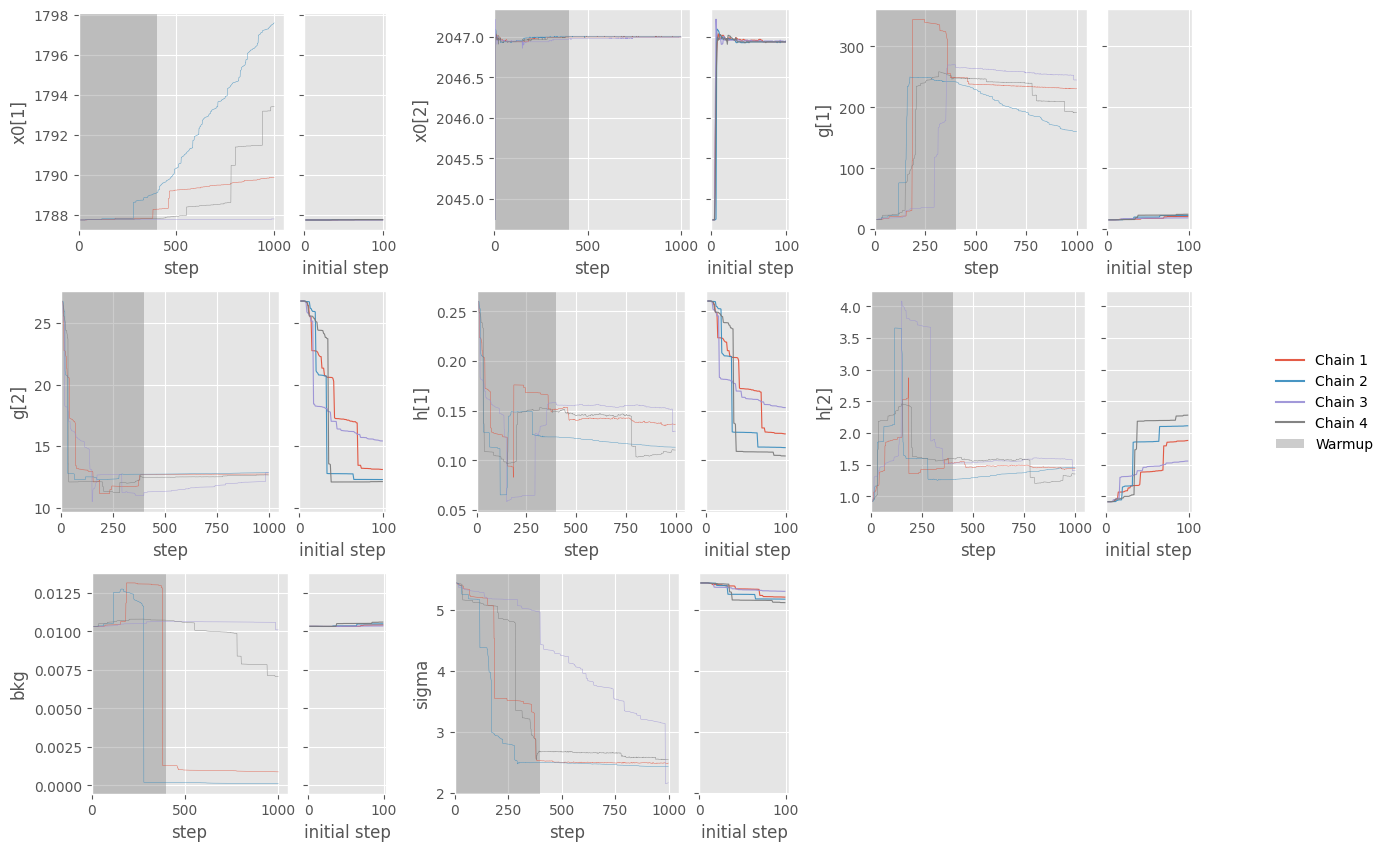

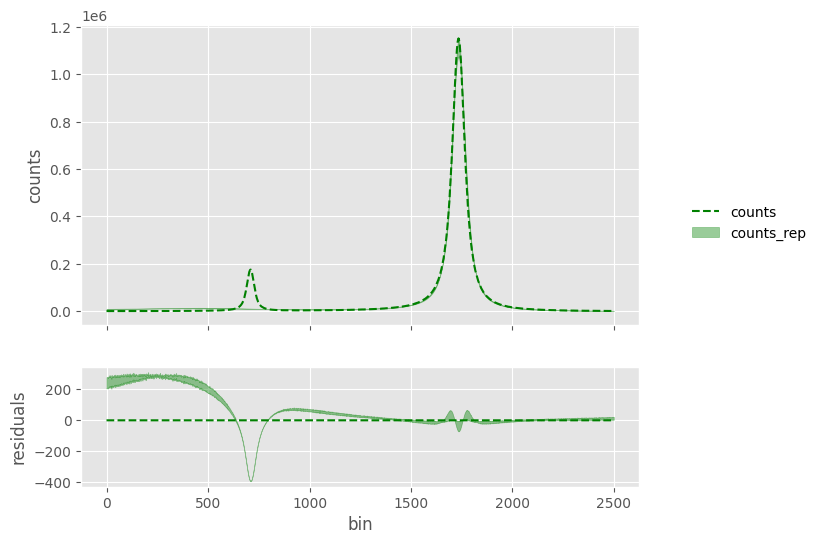

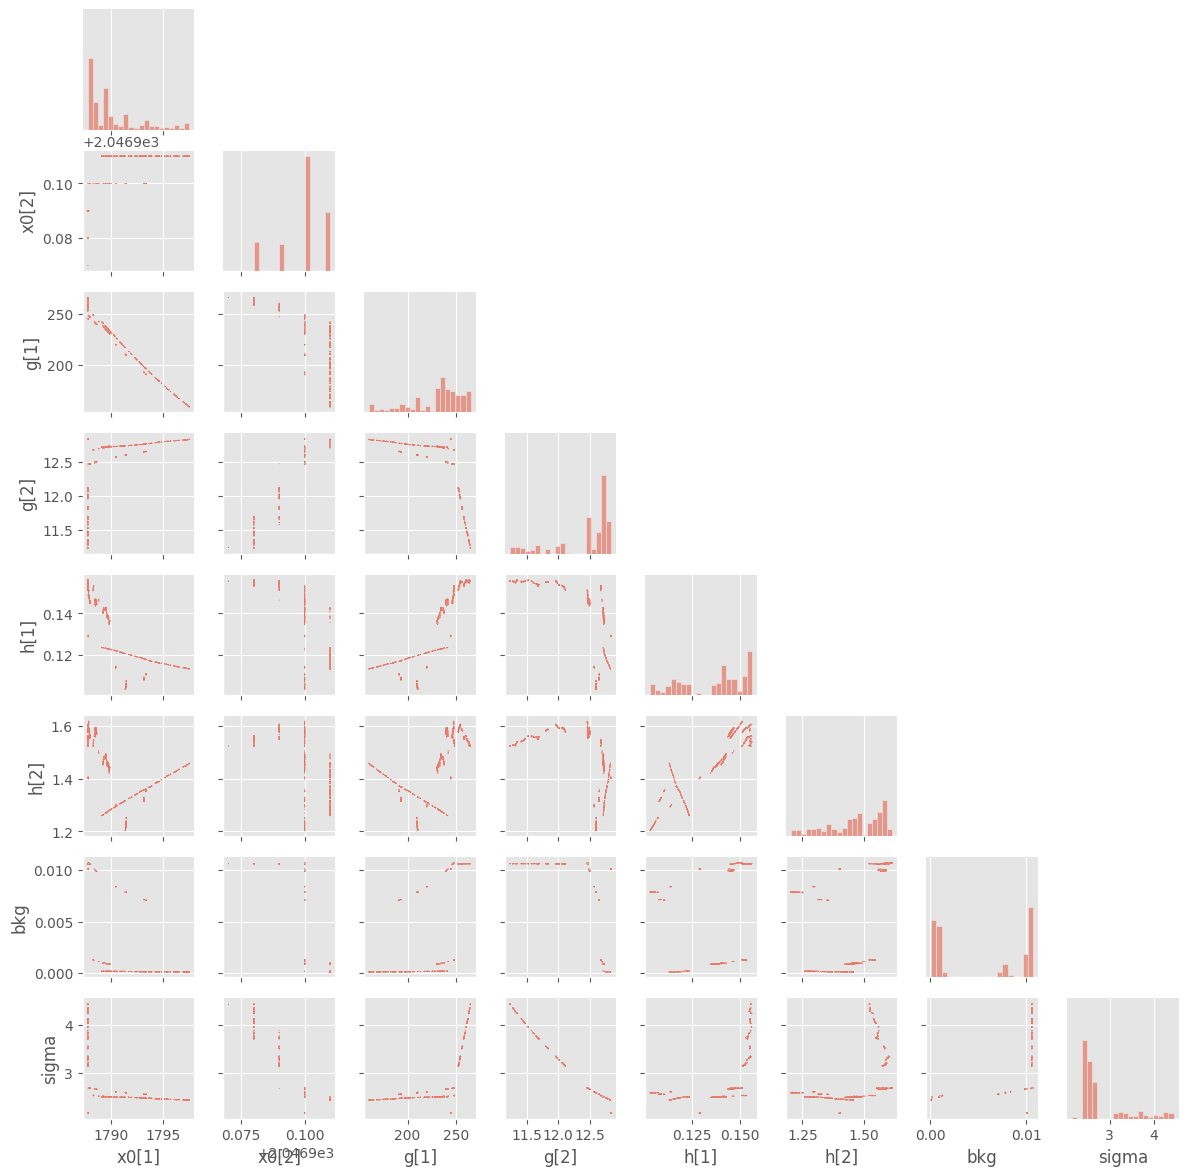

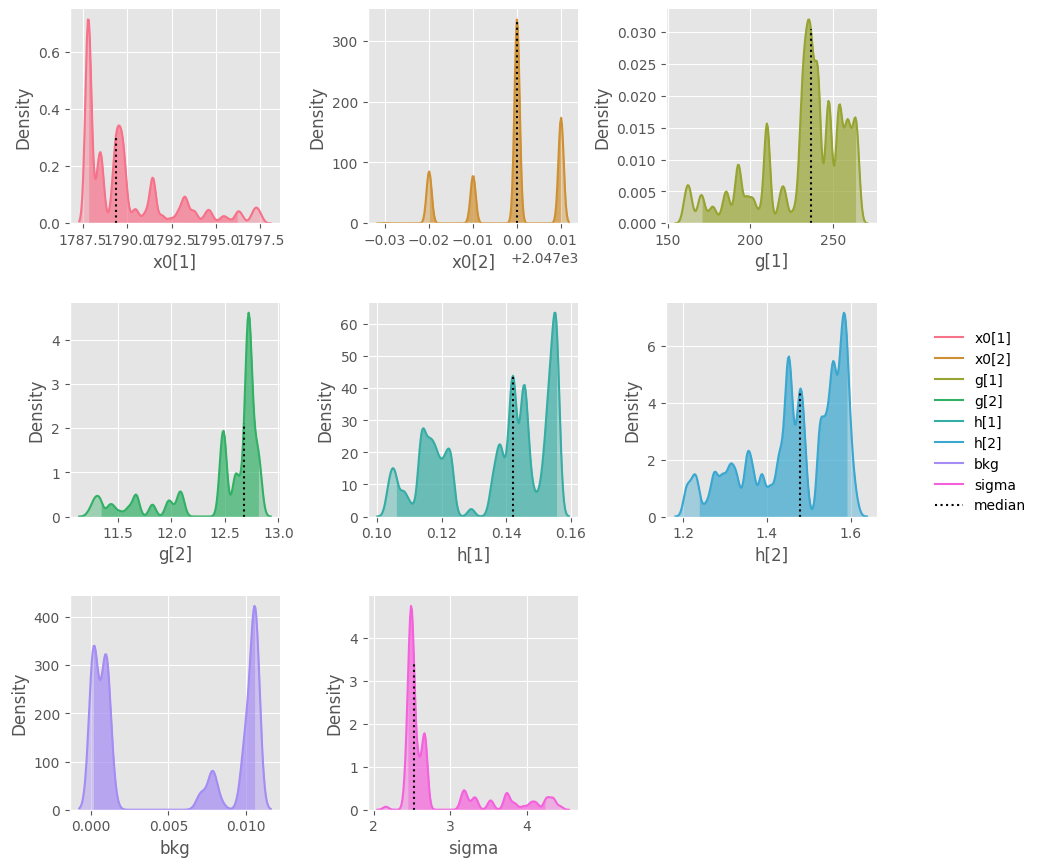

In [22]:
plotter.col_wrap=3
plotter.add_fit(fit, fit_title='sigma')
plotter.convergence_plot(initial_steps=100)
plotter.predictive_check('counts_rep', data=data, data_key='counts')
plotter.pair_grid()
plotter.kde_plot(hue='variable')
#plt.close()
#plotter.add_lines([1842, 2047, 6, 13.2, 0.0526, 1, 2838, true_weights[1], s.sigma,])
#plotter.get_current_figure()


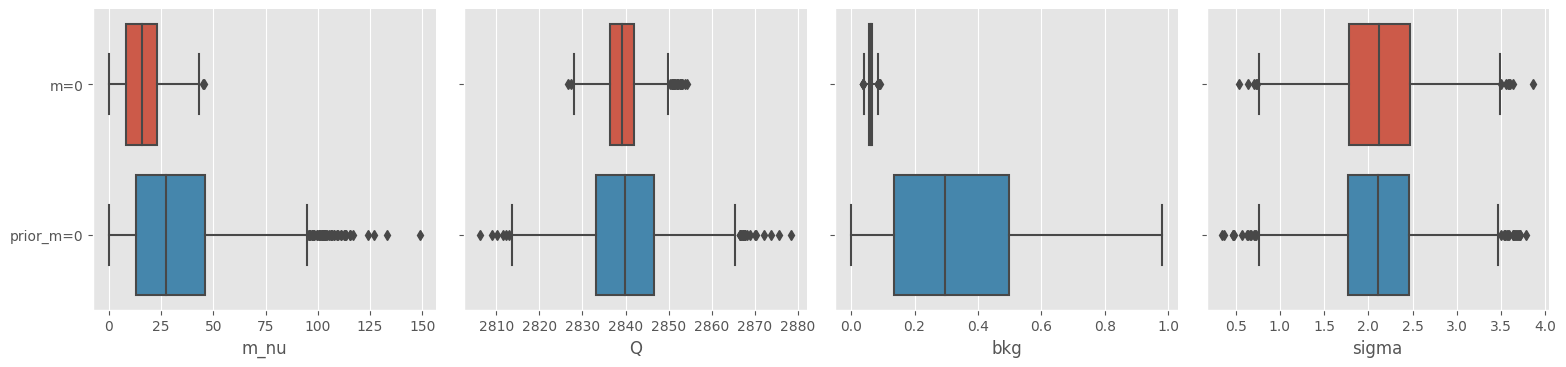

In [78]:
plotter.cat_plot(fit_titles='all')

In [79]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(processes=4)

In [92]:
m_nus=np.arange(0, 64)
metric = {'inv_metric': fit.metric[0]}
def m0_coverage(m):
    s.update_spectrum([(HoSpectrum, [m], A_Ho)])
    data={'N_bins': len(x)-1, 
          'N_window': n_window,
          'N_peaks': 6,
          'x': x, 
          'counts': s.sample()[1],
          'p_Q': 2840,
          'p_m': 40,
          'p_FWHM': FWHM,
          'p_N': s.n_events,
          'prior': 0
    }
    #metric = {'inv_metric': fit.metric[0]}
    #step_size = fit.step_size[0]
    init_files = inits_from_priors(model, fit_prior, 1)

    fit = model.sample(data,
                       chains=1,
                       iter_warmup=400,
                       iter_sampling=1000,
                       save_warmup=False,
                       show_progress=False,
                       inits=init_files,
                       metric=metric,
                       adapt_delta=0.9)
    return fit

s.n_spectra=64
results = pool.map(m0_coverage, m_nus)

23:44:53 - cmdstanpy - INFO - CmdStan start processing
23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - CmdStan start processing
23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - CmdStan start processing
23:44:53 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - CmdStan start processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:29 - cmdstanpy - INFO - Chain [1] done processing
23:45:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.stan', line 52, column 4 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirst.stan', line 52, column 4 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but 

In [93]:
p = FitPlotter(col_wrap=4)
for i in range(len(results)):
    p.add_fit(results[i], fit_title='fit '+ str(i))

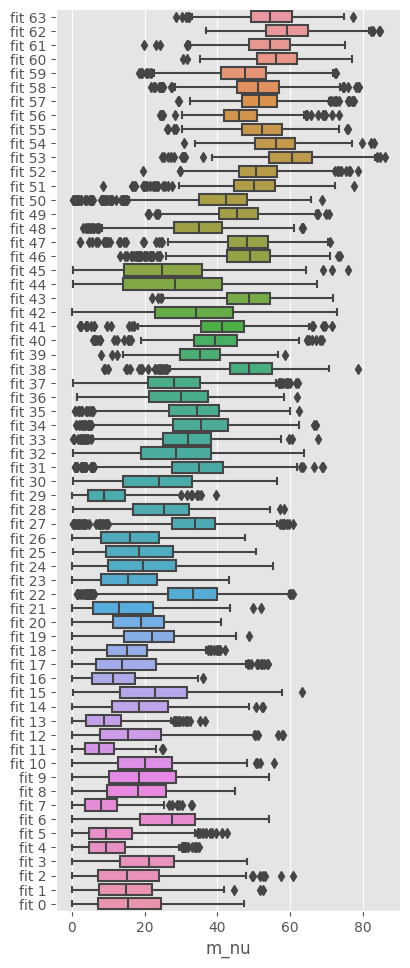

In [94]:
p.cat_plot(parameters='m_nu', fit_titles='all', aspect=0.8)
plt.close()
p.resize(5,12)
#p.get_current_figure()

In [95]:
posteriors=[]
hdis=[]
mzero=0
for f in results:
   posteriors.append(f.stan_variable('m_nu'))
   hdis.append(hdi(posteriors[-1], prob=0.95))
   if min(posteriors[-1])==hdis[-1][0]:
      mzero+=1
   #print(hdis[-1],min(posteriors[-1]))
mzero

20

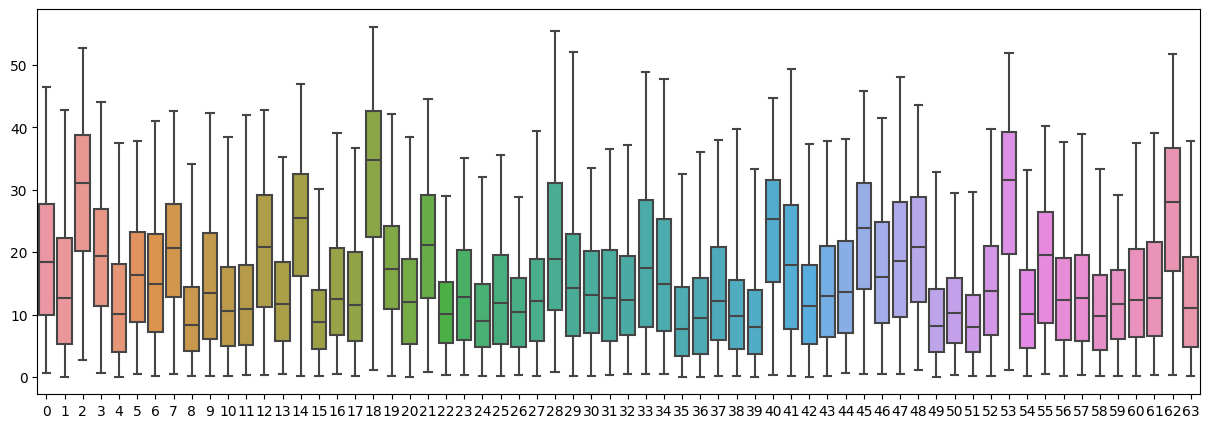

In [7]:
import pickle
import pprint
pkl_file = open('data/m0_64_posteriors.pkl', 'rb')

data1 = pickle.load(pkl_file)

pkl_file.close()
box = sns.boxplot(data1, whis=[1, 99], showfliers=False)
box.figure.set_size_inches(15, 5)

In [96]:
import pickle

output = open('./data/multi_m_64.pkl', 'wb')
pickle.dump(results, output)
output.close()

output = open('./data/multi_m_posteriors.pkl', 'wb')
pickle.dump(posteriors, output)
output.close()

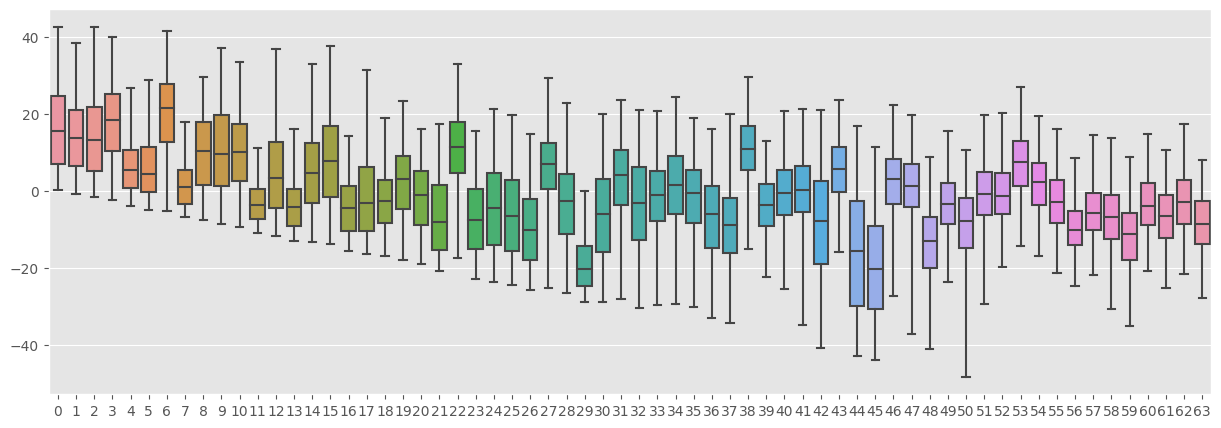

In [124]:
res=[np.array(posteriors[i])-m_nus[i] for i in range(len(m_nus))]
box = sns.boxplot(res, whis=[1, 99], showfliers=False)
box.figure.set_size_inches(15, 5)

In [ ]:
stan_file= "HoFirstSBC.stan"
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={"STAN_THREADS": True,"jN":4})

14:21:53 - cmdstanpy - INFO - compiling stan file /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC.stan to exe file /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC
14:23:18 - cmdstanpy - INFO - compiled model executable: /home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC


In [ ]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(processes=4)

def SBC_sample(data):
    fit = model.sample(data,
                       chains=1,
                       iter_warmup=400,
                       iter_sampling=399,
                       save_warmup=False,
                       show_progress=False,
                       inits={'Q': 2800,'m_mu': 0.1, 'bkg': 0.1, 'sigma':1})
    return sum(fit.draws_pd(['lt_m', 'lt_Q', 'lt_b', 'lt_s',]).to_numpy())

pool = ThreadPool(processes=4)
results = pool.map(SBC_sample, [data]*200)

19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - CmdStan start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC.stan', line 103, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -nan, but must be nonnegative! (in '/home/pietro/work/TESI/BAYNES/baynes/examples/HoSpectrum/HoFirstSBC.stan', line 103, column 2 to column 96)
	Exception: poisson_lpmf: Rate parameter[1] is -n

In [ ]:
results = np.array(results).transpose()
ranks={'lt_m': [], 'lt_Q': [], 'lt_b': [], 'lt_s': []}
keys = ['lt_m', 'lt_Q', 'lt_b', 'lt_s']
for i in range(4):
    ranks[keys[i]].extend(results[i])

with open('sbc_sigma_400', "w", encoding="utf-8") as f:
    json.dump(ranks, f, ensure_ascii=False, indent=4)

In [ ]:
def SBC_plot(data, n_bins, percs=[0.005, 0.995]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', hue='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='green', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='green', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

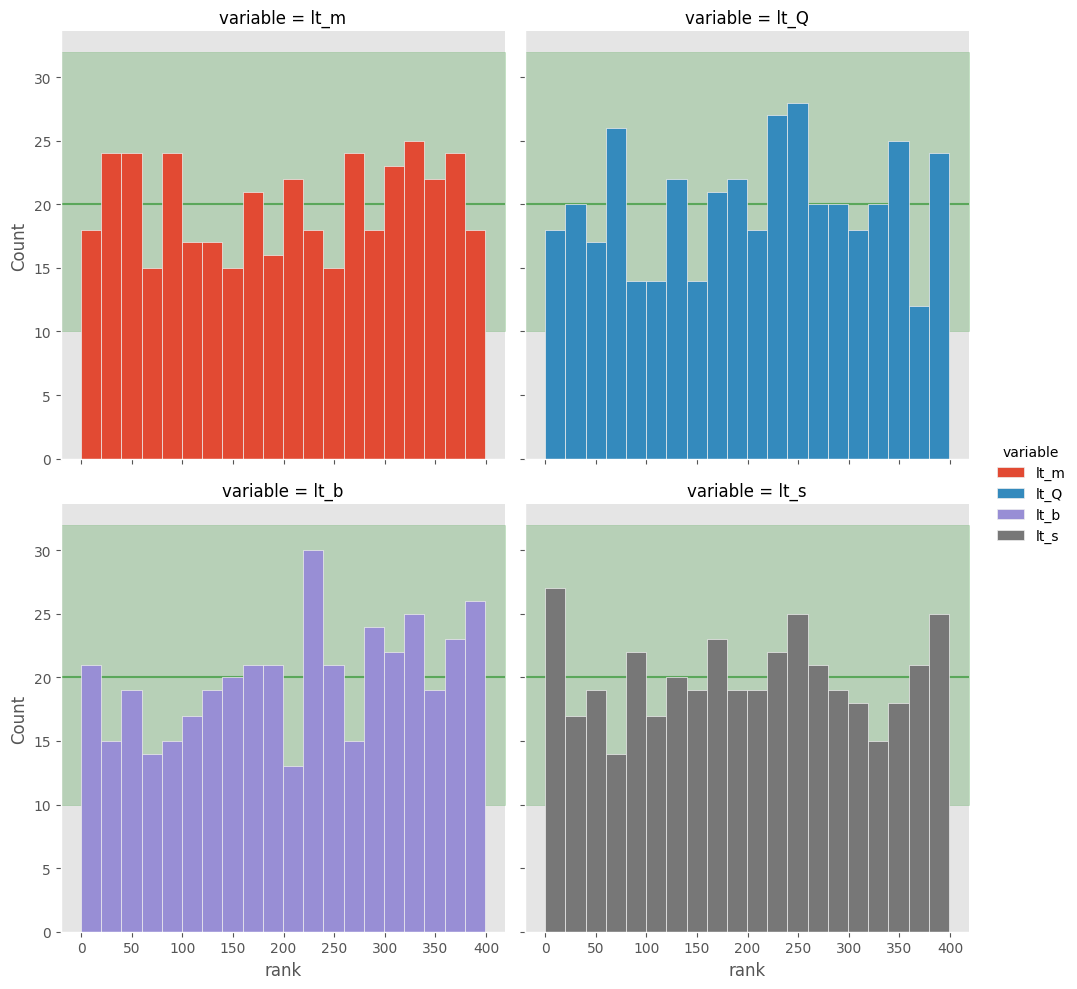

In [ ]:
fig = SBC_plot('sbc_sigma_400', 20)